In [1]:
from MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx
from SimPEG import (Mesh, Maps, SolverLU, DataMisfit, Regularization,
                    Optimization, InvProblem, Inversion, Directives, Utils)
from scipy.constants import mu_0
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
rxloc = np.r_[0.]
srcloc = np.r_[0.]
frequency = np.logspace(-3, 2, 25)
rxType = "Zxy"

if rxType == "Zxy":
    rx = ZxyRx(rxloc, component="both", frequency=frequency)
    rxList = [rx]
elif rxType == "AppredPha":
    rx = AppResPhaRx(rxloc, component="both", frequency=frequency)
    rxList = [rx]
    
src = MT1DSrc(rxList, loc=srcloc)
survey = MT1DSurvey([src])
mesh = survey.setMesh(sigma=0.01, max_depth_core=5000., ncell_per_skind=10, n_skind=2)
sigma = np.ones(mesh.nC) * 0.01

prob = MT1DProblem(mesh, sigmaMap=Maps.ExpMap(mesh), verbose=False)
prob.pair(survey)

>> Smallest cell size = 50 m
>> Padding distance = 316227 m
>> # of padding cells 28


In [3]:
rho_half = 100.
rho_target = 10.
depth = 2000.
thickness = 1000.
tsig = thickness * 1./rho_target

layer_inds = np.logical_and(mesh.vectorCCx<-depth, mesh.vectorCCx>-depth-thickness)
sigma = np.ones(mesh.nC) * 1./rho_half
sigma[layer_inds] = 1./rho_target

In [16]:

mtrue = np.log(sigma)
m0 = np.log(1./rho_half) * np.ones(mesh.nC)

std = 0.1
survey.dobs = survey.makeSyntheticData(mtrue, 0.1, force=True)
survey.std = std
survey.eps = 1e-5*np.linalg.norm(survey.dobs)

dmisfit = DataMisfit.l2_DataMisfit(survey)
reg = Regularization.Tikhonov(mesh, alpha_s=0.01, alpha_x=1.)
opt = Optimization.InexactGaussNewton(maxIter=10, LSshorten=0.5)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)

# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prob.counter = opt.counter = Utils.Counter()
opt.remember('xc')

mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.30e+00  1.86e+03  0.00e+00  1.86e+03    4.43e+02      0              
   1  1.30e+00  1.72e+02  3.55e+01  2.18e+02    5.00e+01      0              
   2  2.59e-01  1.21e+02  3.29e+01  1.29e+02    3.70e+01      0              
   3  2.59e-01  1.13e+02  3.13e+01  1.21e+02    3.43e+01      1              
   4  5.19e-02  1.08e+02  2.97e+01  1.09e+02    1.68e+01      0   Skip BFGS  
   5  5.19e-02  1.07e+02  3.25e+01  1.08e+02    2.11e+01      1              
   6  1.04e-02  1.06e+02  3.83e+01  1.07e+02    1.88e+01      0   

In [17]:
from simpegem1d import Utils1D

(-5000.0, 0.0)

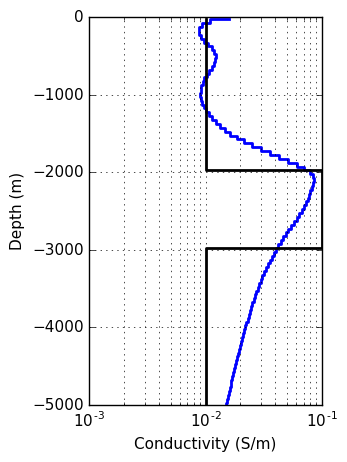

In [18]:
import matplotlib
matplotlib.rcParams["font.size"] = 11
figsize(3, 5)
sigopt = np.repeat(np.exp(mopt), 2, axis=0)
sigtrue = np.repeat(np.exp(mtrue), 2, axis=0)
z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
plt.plot(sigopt, z, 'b', lw=2)
plt.plot(sigtrue, z, 'k', lw=2)
plt.xscale("log")
plt.xlabel("Conductivity (S/m)")
plt.ylabel("Depth (m)")
plt.grid(True, which='both')
plt.ylim(-5000., 0.)

In [19]:
survey.dobs

array([ 0.00068129,  0.00048951,  0.00078614,  0.00078213,  0.00102297,
        0.00092418,  0.0011877 ,  0.00086028,  0.00165001,  0.00124394,
        0.00168354,  0.00152185,  0.00250011,  0.00200235,  0.00297022,
        0.00246749,  0.00321879,  0.00256483,  0.00440824,  0.00288136,
        0.00558893,  0.00447467,  0.00632249,  0.00605508,  0.00631815,
        0.00646156,  0.00767685,  0.0085276 ,  0.00688418,  0.01533382,
        0.0116785 ,  0.01962734,  0.01959266,  0.02429398,  0.02507548,
        0.04807234,  0.03810523,  0.05523471,  0.07110259,  0.0642833 ,
        0.08646976,  0.07989873,  0.08493211,  0.0939201 ,  0.12491529,
        0.10549141,  0.15364248,  0.13534273,  0.21806709,  0.18884909])

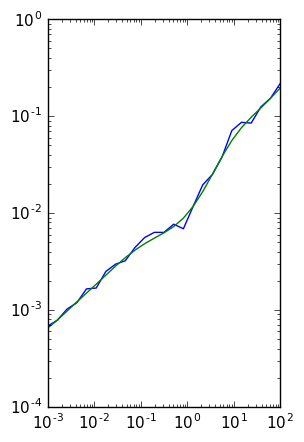

In [20]:
plt.loglog(frequency, survey.dobs.reshape((survey.nFreq, 2))[:,0])
plt.loglog(frequency, invProb.dpred.reshape((survey.nFreq, 2))[:,0])

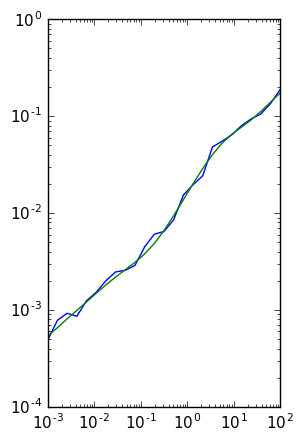

In [21]:
plt.loglog(frequency, survey.dobs.reshape((survey.nFreq, 2))[:,1])
plt.loglog(frequency, invProb.dpred.reshape((survey.nFreq, 2))[:,1])